In [1]:
import torch
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
words=open("names.txt",'r').read().splitlines()

In [3]:
chars=sorted(list(set(''.join(words))))   
stoi={s: i+1 for i,s in enumerate(chars)}
stoi['.']=0
itos={i:s for s,i in stoi.items()}
vocab_size=len(itos)
print(vocab_size)
print(itos)

27
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size=3
def create_dataset(words):
    
    x,y=[],[]
    for w in words:
        context=[0]*block_size
        for ch in w+'.':
            ix=stoi[ch]
            x.append(context)
            y.append(ix)
            #print(''.join(itos[i] for i in context),'---->',itos[ix])
            context=context[1:]+[ix]

    x=torch.tensor(x)
    y=torch.tensor(y)

    return x,y  

import random 
random.seed(32)
random.shuffle(words)
n1=int(0.8*len(words))
n2=int(0.9*len(words))

xtr,ytr=create_dataset(words[:n1])
xdev,ydev=create_dataset(words[n1:n2])
xte,yte=create_dataset(words[n2:])

In [192]:
n_emb=10
n_hidden=200


g=torch.Generator().manual_seed(2147483647)
c=torch.randn((27,n_emb),generator=g)
w1=torch.randn((n_emb*block_size,n_hidden),generator=g)*0.2
b1=torch.randn((n_hidden,),generator=g) *0.01
w2=torch.randn((n_hidden,vocab_size),generator=g)*0.01
b2=torch.randn((vocab_size,),generator=g)*0

bngain=torch.ones((1,n_hidden))
bnbias=torch.zeros((1,n_hidden))
bnmean_running=torch.zeros((1,n_hidden))
bnstd_running=torch.ones((1,n_hidden))
parameters=[c,w1,b2,w2,b2,bnbias,bngain]
print(sum(p.nelement() for p in parameters))
for i in parameters:
    i.requires_grad=True

12124


In [203]:
max_steps=200000
batch_size=32
lossi=[]
for i in range(max_steps):
    ix=torch.randint(0,xtr.shape[0],(batch_size,),generator=g)
    xb,yb=xtr[ix],ytr[ix]

    emb=c[xb]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@w1#+b1 
    bnmeani=hpreact.mean(0,keepdim=True)
    bnstdi=hpreact.std(0,keepdim=True)
    hpreact=bngain*(hpreact-bnmeani)/bnstdi+bnbias

    with torch.no_grad():
        bnmean_running=0.999*bnmean_running+0.001*bnmeani
        bnstd_running=0.999*bnstd_running+0.001*bnstdi 

    h=torch.tanh(hpreact)
    logits=h@w2+b2 
    loss=F.cross_entropy(logits,yb)

    for p in parameters:
        p.grad=None 
    loss.backward()

    lr=0.1 if i<100000 else 0.01
    for p in parameters:
        p.data+=-lr*p.grad 
    
    if i %10000==0:
        print(f"{i:7d}/{max_steps:7d}:{loss.item():4f}")
    lossi.append(loss.log10().item())
    
    

      0/ 200000:2.447564
  10000/ 200000:2.203615
  20000/ 200000:2.169255
  30000/ 200000:2.075413
  40000/ 200000:2.159444
  50000/ 200000:2.208492
  60000/ 200000:2.008277
  70000/ 200000:1.917105
  80000/ 200000:2.491738
  90000/ 200000:1.664827
 100000/ 200000:1.966994
 110000/ 200000:1.950982
 120000/ 200000:1.881359
 130000/ 200000:2.301716
 140000/ 200000:1.905667
 150000/ 200000:2.520334
 160000/ 200000:2.199930
 170000/ 200000:2.043748
 180000/ 200000:2.403672
 190000/ 200000:1.840428


In [189]:
xb.shape

torch.Size([32, 3])

In [190]:
emb.shape

torch.Size([1, 3, 10])

In [188]:
embcat.shape

torch.Size([1, 30])

In [159]:
emb[1]

tensor([[ 0.1190, -0.5144, -1.1409, -2.1459,  0.4369,  0.1882,  1.5173,  0.2643,
          0.6129,  1.7643],
        [ 0.0522,  1.2470,  0.4261, -2.0220,  0.4723, -0.3381,  0.5069,  1.0234,
         -0.3265, -1.6662],
        [-1.5507,  0.4345, -0.7336, -0.9881,  1.0594, -0.1270,  0.9475, -1.1667,
         -0.2254,  1.5909]], grad_fn=<SelectBackward0>)

torch.Size([1, 200])

In [176]:
hpreact.mean(0,keepdim=True).shape

torch.Size([1, 200])

In [127]:
hpreact[:,0].mean()

tensor(-1.2598, grad_fn=<MeanBackward0>)

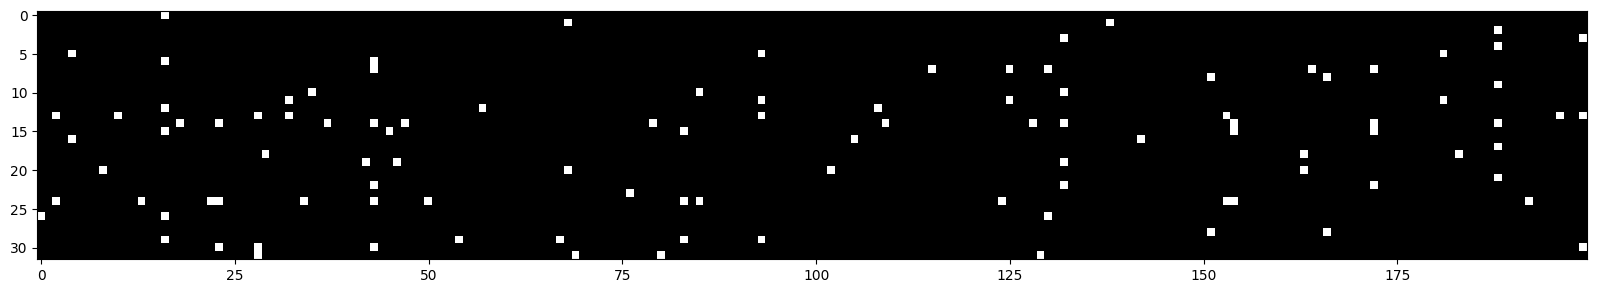

In [55]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')


(array([  1.,   0.,   2.,   4.,   4.,   2.,   8.,  10.,  17.,  20.,  37.,
         47.,  55.,  74., 100., 144., 164., 213., 233., 307., 325., 394.,
        367., 440., 412., 417., 361., 360., 333., 321., 292., 213., 167.,
        153., 106.,  86.,  67.,  38.,  40.,  13.,  19.,  10.,   8.,  10.,
          3.,   1.,   0.,   0.,   0.,   2.]),
 array([-4.19595051, -4.02230186, -3.8486532 , -3.67500455, -3.5013559 ,
        -3.32770724, -3.15405859, -2.98040994, -2.80676128, -2.63311263,
        -2.45946398, -2.28581532, -2.11216667, -1.93851802, -1.76486937,
        -1.59122071, -1.41757206, -1.24392341, -1.07027475, -0.8966261 ,
        -0.72297745, -0.54932879, -0.37568014, -0.20203149, -0.02838284,
         0.14526582,  0.31891447,  0.49256312,  0.66621178,  0.83986043,
         1.01350908,  1.18715774,  1.36080639,  1.53445504,  1.70810369,
         1.88175235,  2.055401  ,  2.22904965,  2.40269831,  2.57634696,
         2.74999561,  2.92364427,  3.09729292,  3.27094157,  3.44459023,
 

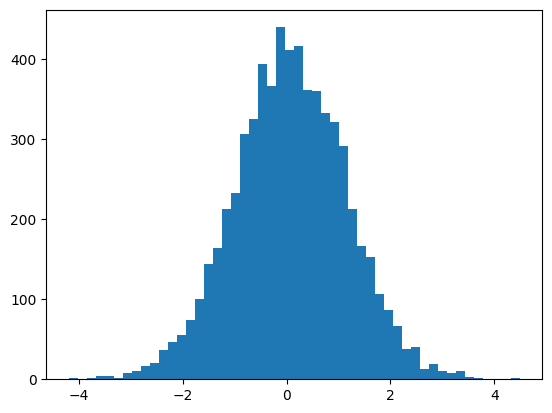

In [56]:
(plt.hist(hpreact.view(-1).tolist(),50))

(array([ 11.,  15.,  34.,  47.,  65.,  53.,  76.,  99., 108.,  96., 136.,
        128., 133., 114., 154., 171., 154., 171., 180., 196., 145., 200.,
        191., 171., 212., 176., 178., 192., 184., 169., 184., 177., 164.,
        192., 157., 176., 177., 165., 174., 139., 112., 128., 123.,  88.,
         96.,  67.,  57.,  33.,  27.,   5.]),
 array([-0.97051972, -0.93155138, -0.89258303, -0.85361469, -0.81464635,
        -0.775678  , -0.73670966, -0.69774132, -0.65877297, -0.61980463,
        -0.58083628, -0.54186794, -0.5028996 , -0.46393125, -0.42496291,
        -0.38599457, -0.34702622, -0.30805788, -0.26908953, -0.23012119,
        -0.19115285, -0.1521845 , -0.11321616, -0.07424782, -0.03527947,
         0.00368887,  0.04265722,  0.08162556,  0.1205939 ,  0.15956225,
         0.19853059,  0.23749893,  0.27646728,  0.31543562,  0.35440397,
         0.39337231,  0.43234065,  0.471309  ,  0.51027734,  0.54924568,
         0.58821403,  0.62718237,  0.66615072,  0.70511906,  0.7440874 ,
 

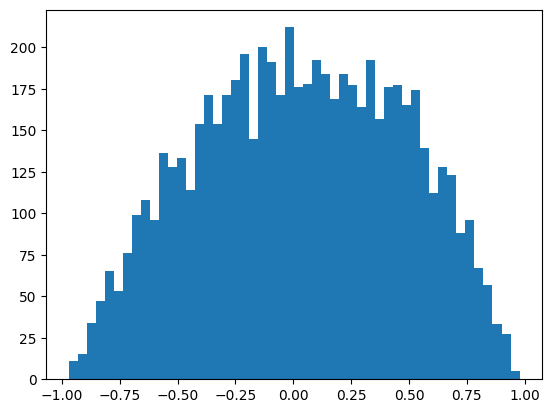

In [51]:
(plt.hist(h.view(-1).tolist(),50))

In [42]:
logit=torch.tensor([1.0,2.0,3.0,4.0])
prob=torch.softmax(logit,dim=0)
loss=-prob

tensor(-0.2369)

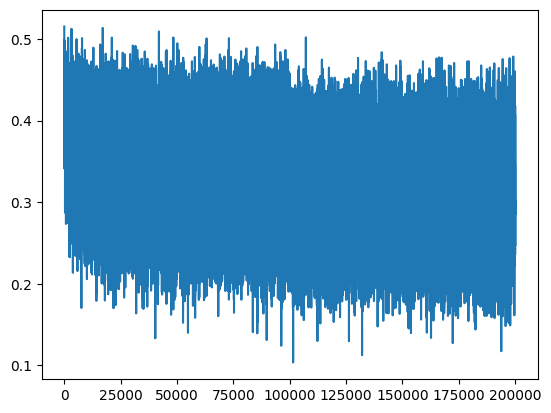

In [130]:
plt.plot(lossi)

torch.Size([32, 3, 10])

In [195]:
with torch.no_grad():
    emb=c[xtr]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@w1#+b1
    bnmean=hpreact.mean(0,keepdim=True)
    bnstd=hpreact.std(0,keepdim=True) 

In [204]:
@torch.no_grad()
def split_loss(split):
    x,y={
        'train':(xtr,ytr),
        'val':(xdev,ydev),
        'test':(xte,yte),
    }[split]
    emb=c[x]
    embcat=emb.view(emb.shape[0],-1)
    hpreact=embcat@w1#+b1 
    hpreact=bngain*(hpreact-bnmean_running)/bnstd_running+bnbias
    h=torch.tanh(hpreact)
    logits=h@w2+b2 
    loss=F.cross_entropy(logits,y)
    print(split,loss.item())

split_loss("train")
split_loss("val")

train 2.048114061355591
val 2.0936617851257324


In [1]:
g=torch.Generator().manual_seed(2147483647+2)

for _ in range(20):
    out=[]
    context=[0]*block_size
    
    while True:
        emb=c[torch.tensor([context])]
        embcat=emb.view(emb.shape[0],-1)
        hpreact=embcat@w1#+b1 
        hpreact=bngain*(hpreact-bnmean_running)/bnstd_running+bnbias
        h=torch.tanh(hpreact)
        # h=torch.tanh(emb.view(1,-1)@w1+b1)
        logits=h@w2+b2 
        probs=F.softmax(logits,dim=1)

        ix = torch.multinomial(probs,num_samples=1,generator=g).item()

        context=context[1:]+[ix]
        out.append(ix)
        if ix==0:
            break 
    print((''.join(itos[i] for i in out)))

NameError: name 'torch' is not defined

[tensor(-0.0065), tensor(0.9985)]
[tensor(0.0007), tensor(1.0008)]


(array([2.33403821e-05, 0.00000000e+00, 2.33403821e-05, 2.33403821e-05,
        1.16701910e-04, 1.86723056e-04, 3.26764621e-04, 6.76871833e-04,
        9.80296046e-04, 1.75052671e-03, 2.80084585e-03, 4.45801297e-03,
        7.11881653e-03, 1.08299373e-02, 1.72018616e-02, 2.67480481e-02,
        4.03788610e-02, 5.76507437e-02, 8.59626271e-02, 1.19012608e-01,
        1.61071887e-01, 2.11557223e-01, 2.71121803e-01, 3.31806871e-01,
        3.83389009e-01, 4.18773077e-01, 4.28972822e-01, 4.16555712e-01,
        3.71392056e-01, 3.20230042e-01, 2.66920535e-01, 2.00050415e-01,
        1.53252863e-01, 1.15534891e-01, 7.94740009e-02, 5.46398040e-02,
        3.78814401e-02, 2.53476549e-02, 1.68050751e-02, 1.00363643e-02,
        6.67534184e-03, 3.80448228e-03, 2.45074012e-03, 1.84389018e-03,
        1.02697681e-03, 4.43466765e-04, 3.50105731e-04, 2.33403821e-04,
        1.16701910e-04, 4.66807641e-05]),
 array([-5.65927887, -5.44505787, -5.23083687, -5.01661587, -4.80239487,
        -4.58817387, 

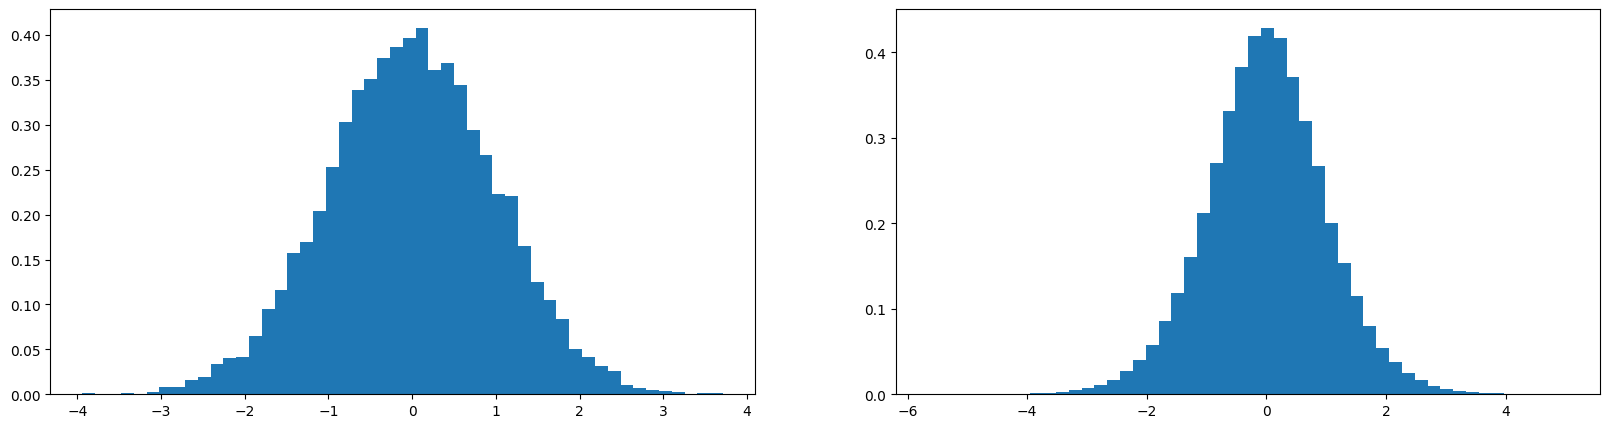

In [113]:
xrand=torch.randn(1000,10)
wrand=torch.randn(10,200)
yrand=xrand@wrand/10**0.5
print([xrand.mean(),xrand.std()])
print([yrand.mean(),yrand.std()])
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(xrand.view(-1).tolist(),50,density=True)
plt.subplot(122)
plt.hist(yrand.view(-1),50,density=True)
